<a href="https://colab.research.google.com/github/Esubaalew/2merkato/blob/main/activate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import time
from collections import defaultdict


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)
print("Using device:", device)

Using device: cuda


**Data Preparation**

In [2]:
def prepare_data(train_subset_size=10000, batch_size=128):
    """Prepare MNIST dataset with balanced subset"""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


    subset_indices = []
    for i in range(10):  # MNIST has 10 classes
        class_indices = torch.where(train_dataset.targets == i)[0]
        subset_indices.extend(class_indices[:train_subset_size//10].tolist())

    train_subset = torch.utils.data.Subset(train_dataset, subset_indices)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


train_loader, test_loader = prepare_data()

100%|██████████| 9.91M/9.91M [00:00<00:00, 61.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.69MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 15.2MB/s]


**model Defnition**

In [3]:
class SimpleDNN(nn.Module):
    """Configurable DNN with gradient tracking"""
    def __init__(self, input_size, hidden_sizes, output_size, activation_fn):
        super(SimpleDNN, self).__init__()
        self.activation_name = activation_fn.__class__.__name__
        layers = []
        in_dim = input_size


        for i, h in enumerate(hidden_sizes):
            layers.append(nn.Linear(in_dim, h))
            layers.append(activation_fn)
            in_dim = h


        layers.append(nn.Linear(in_dim, output_size))
        self.layers = nn.ModuleList(layers)
        self.gradient_stats = defaultdict(list)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for layer in self.layers:
            x = layer(x)
        return x

    def record_gradients(self):
        """Record gradient statistics for each layer"""
        for i, layer in enumerate(self.layers):
            if isinstance(layer, nn.Linear):
                if layer.weight.grad is not None:
                    grad_norm = layer.weight.grad.data.norm().item()
                    self.gradient_stats[f'layer_{i}_grad_norm'].append(grad_norm)

Training  Function

In [4]:
def train_model(model, train_loader, test_loader, epochs=15, lr=0.001):
    """Enhanced training function with metrics tracking"""
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    metrics = {
        'train_loss': [],
        'test_acc': [],
        'grad_norms': defaultdict(list),
        'epoch_times': []
    }

    print(f"\nTraining {model.activation_name} model with {len([l for l in model.layers if isinstance(l, nn.Linear)])-1} hidden layers...")

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            model.record_gradients()
            optimizer.step()
            running_loss += loss.item() * data.size(0)


        epoch_time = time.time() - start_time
        metrics['epoch_times'].append(epoch_time)
        avg_loss = running_loss / len(train_loader.dataset)
        metrics['train_loss'].append(avg_loss)


        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

        accuracy = 100 * correct / total
        metrics['test_acc'].append(accuracy)


        for k, v in model.gradient_stats.items():
            metrics['grad_norms'][k].append(np.mean(v) if v else 0)
        model.gradient_stats.clear()

        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Test Acc: {accuracy:.2f}% | Time: {epoch_time:.2f}s")

    return metrics

# Experiment 1: Activation Function Comparison
*This experiment compares Sigmoid, Tanh, and ReLU activation functions to demonstrate how ReLU helps with the vanishing gradient problem.*




EXPERIMENT 1: ACTIVATION FUNCTION COMPARISON


Training Sigmoid model with 3 hidden layers...
Epoch 1/15 | Loss: 2.1760 | Test Acc: 44.27% | Time: 2.54s
Epoch 2/15 | Loss: 1.6743 | Test Acc: 55.73% | Time: 1.83s
Epoch 3/15 | Loss: 1.2731 | Test Acc: 64.90% | Time: 1.83s
Epoch 4/15 | Loss: 1.0120 | Test Acc: 75.61% | Time: 2.02s
Epoch 5/15 | Loss: 0.8309 | Test Acc: 79.92% | Time: 1.79s
Epoch 6/15 | Loss: 0.6893 | Test Acc: 84.61% | Time: 1.82s
Epoch 7/15 | Loss: 0.5707 | Test Acc: 88.48% | Time: 2.75s
Epoch 8/15 | Loss: 0.4587 | Test Acc: 90.01% | Time: 1.82s
Epoch 9/15 | Loss: 0.3613 | Test Acc: 91.07% | Time: 1.83s
Epoch 10/15 | Loss: 0.2903 | Test Acc: 91.67% | Time: 2.18s
Epoch 11/15 | Loss: 0.2385 | Test Acc: 92.18% | Time: 2.25s
Epoch 12/15 | Loss: 0.1999 | Test Acc: 92.51% | Time: 2.09s
Epoch 13/15 | Loss: 0.1711 | Test Acc: 93.07% | Time: 2.70s
Epoch 14/15 | Loss: 0.1444 | Test Acc: 93.21% | Time: 1.82s
Epoch 15/15 | Loss: 0.1233 | Test Acc: 93.41% | Time: 2.02s

Training Tanh

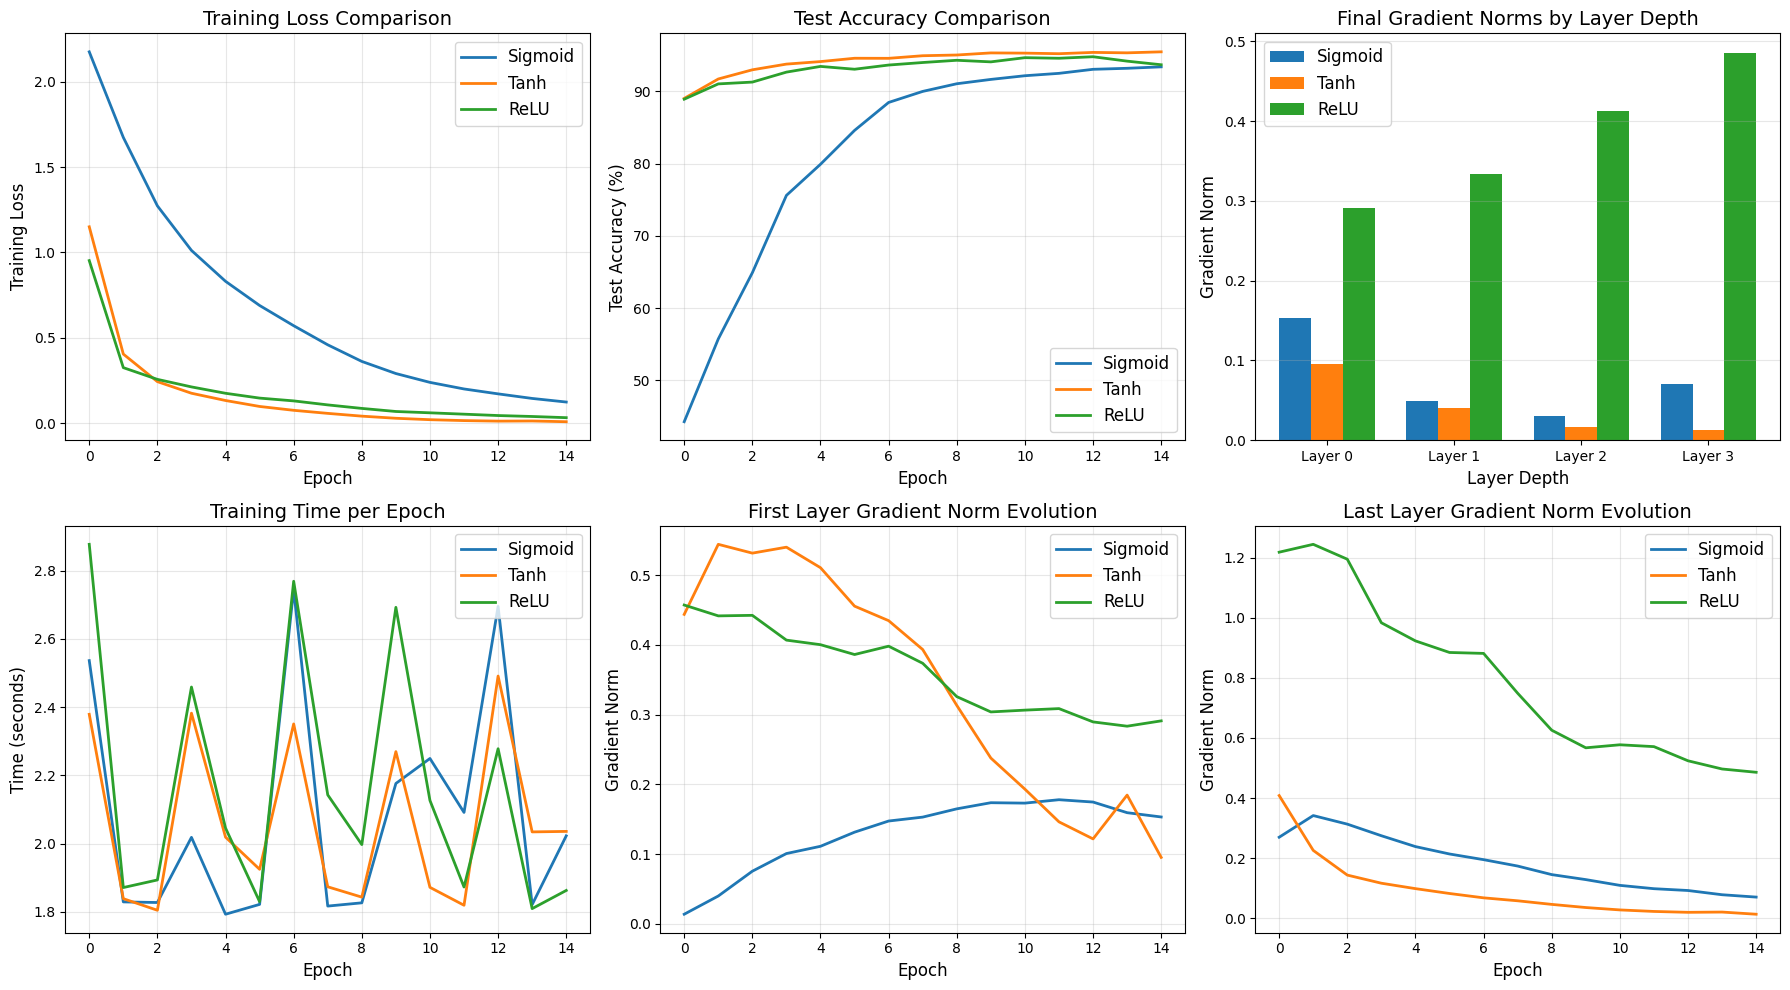


Final Metrics:
Activation Final Loss   Best Acc   Avg Time  
---------------------------------------------
Sigmoid    0.1233       93.41      2.09      
Tanh       0.0078       95.49      2.06      
ReLU       0.0316       94.81      2.17      


In [5]:
def experiment_activation_functions():
    input_size = 28*28
    hidden_sizes = [128, 64, 32]  # Three hidden layers to better show vanishing gradients
    output_size = 10
    epochs = 15

    activations = {
        "Sigmoid": nn.Sigmoid(),
        "Tanh": nn.Tanh(),
        "ReLU": nn.ReLU()
    }

    results = {}

    print("\n" + "="*60)
    print("EXPERIMENT 1: ACTIVATION FUNCTION COMPARISON")
    print("="*60 + "\n")

    for act_name, act_fn in activations.items():
        model = SimpleDNN(input_size, hidden_sizes, output_size, act_fn)
        results[act_name] = train_model(model, train_loader, test_loader, epochs=epochs)


    plt.figure(figsize=(18, 10))


    plt.subplot(2, 3, 1)
    for act_name in activations.keys():
        plt.plot(results[act_name]['train_loss'], label=act_name, linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Training Loss', fontsize=12)
    plt.title('Training Loss Comparison', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)


    plt.subplot(2, 3, 2)
    for act_name in activations.keys():
        plt.plot(results[act_name]['test_acc'], label=act_name, linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Test Accuracy (%)', fontsize=12)
    plt.title('Test Accuracy Comparison', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)


    plt.subplot(2, 3, 3)
    layer_positions = np.arange(len(hidden_sizes)+1)
    width = 0.25
    for i, act_name in enumerate(activations.keys()):
        grad_norms = [results[act_name]['grad_norms'][f'layer_{j}_grad_norm'][-1]
                     for j in range(0, 2*len(hidden_sizes)+1, 2)]
        plt.bar(layer_positions + i*width, grad_norms, width, label=act_name)
    plt.xlabel('Layer Depth', fontsize=12)
    plt.ylabel('Gradient Norm', fontsize=12)
    plt.title('Final Gradient Norms by Layer Depth', fontsize=14)
    plt.xticks(layer_positions + width, [f'Layer {i}' for i in range(len(layer_positions))])
    plt.legend(fontsize=12)
    plt.grid(True, axis='y', alpha=0.3)


    plt.subplot(2, 3, 4)
    for act_name in activations.keys():
        plt.plot(results[act_name]['epoch_times'], label=act_name, linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Time (seconds)', fontsize=12)
    plt.title('Training Time per Epoch', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)


    plt.subplot(2, 3, 5)
    for act_name in activations.keys():
        plt.plot(results[act_name]['grad_norms']['layer_0_grad_norm'], label=act_name, linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Gradient Norm', fontsize=12)
    plt.title('First Layer Gradient Norm Evolution', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)


    plt.subplot(2, 3, 6)
    for act_name in activations.keys():
        last_layer = f'layer_{2*len(hidden_sizes)}_grad_norm'
        plt.plot(results[act_name]['grad_norms'][last_layer], label=act_name, linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Gradient Norm', fontsize=12)
    plt.title('Last Layer Gradient Norm Evolution', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


    print("\nFinal Metrics:")
    print(f"{'Activation':<10} {'Final Loss':<12} {'Best Acc':<10} {'Avg Time':<10}")
    print("-"*45)
    for act_name in activations.keys():
        final_loss = results[act_name]['train_loss'][-1]
        best_acc = max(results[act_name]['test_acc'])
        avg_time = np.mean(results[act_name]['epoch_times'])
        print(f"{act_name:<10} {final_loss:<12.4f} {best_acc:<10.2f} {avg_time:<10.2f}")


experiment_activation_functions()

# Experiment 2: ReLU Variants Comparison
*This experiment compares different ReLU variants to analyze their performance differences.*


EXPERIMENT 2: ReLU VARIANTS COMPARISON


Training ReLU model with 2 hidden layers...
Epoch 1/15 | Loss: 0.7760 | Test Acc: 89.83% | Time: 1.95s
Epoch 2/15 | Loss: 0.2972 | Test Acc: 90.54% | Time: 1.83s
Epoch 3/15 | Loss: 0.2240 | Test Acc: 92.92% | Time: 1.89s
Epoch 4/15 | Loss: 0.1729 | Test Acc: 93.20% | Time: 2.08s
Epoch 5/15 | Loss: 0.1351 | Test Acc: 93.79% | Time: 1.89s
Epoch 6/15 | Loss: 0.1128 | Test Acc: 94.04% | Time: 1.84s
Epoch 7/15 | Loss: 0.0877 | Test Acc: 94.32% | Time: 2.25s
Epoch 8/15 | Loss: 0.0796 | Test Acc: 94.49% | Time: 1.82s
Epoch 9/15 | Loss: 0.0607 | Test Acc: 94.65% | Time: 1.89s
Epoch 10/15 | Loss: 0.0484 | Test Acc: 95.22% | Time: 2.45s
Epoch 11/15 | Loss: 0.0387 | Test Acc: 94.94% | Time: 1.84s
Epoch 12/15 | Loss: 0.0304 | Test Acc: 94.96% | Time: 1.88s
Epoch 13/15 | Loss: 0.0259 | Test Acc: 95.19% | Time: 2.56s
Epoch 14/15 | Loss: 0.0199 | Test Acc: 95.13% | Time: 1.86s
Epoch 15/15 | Loss: 0.0167 | Test Acc: 95.51% | Time: 1.86s

Training LeakyReLU mod

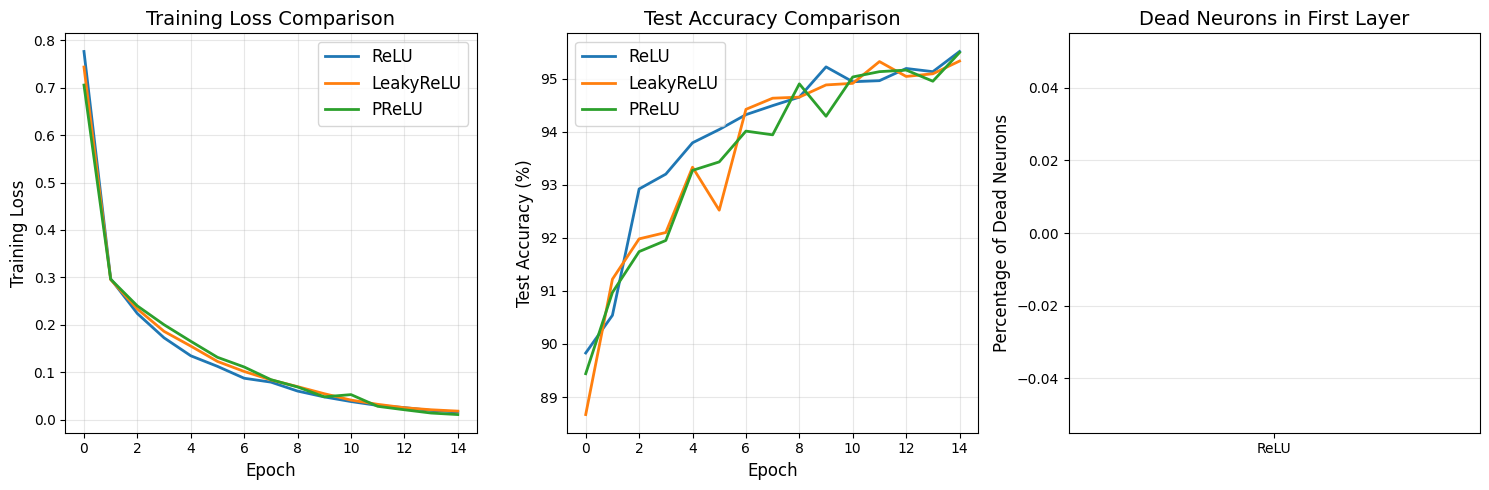


Final Metrics:
Variant    Final Loss   Best Acc   Avg Time  
---------------------------------------------
ReLU       0.0167       95.51      1.99      
LeakyReLU  0.0185       95.33      1.93      
PReLU      0.0112       95.49      1.95      


In [6]:
def experiment_relu_variants():
    input_size = 28*28
    hidden_sizes = [128, 64]
    output_size = 10
    epochs = 15

    relu_variants = {
        "ReLU": nn.ReLU(),
        "LeakyReLU": nn.LeakyReLU(negative_slope=0.01),
        "PReLU": nn.PReLU()
    }

    results = {}

    print("\n" + "="*60)
    print("EXPERIMENT 2: ReLU VARIANTS COMPARISON")
    print("="*60 + "\n")

    for act_name, act_fn in relu_variants.items():
        model = SimpleDNN(input_size, hidden_sizes, output_size, act_fn)
        results[act_name] = train_model(model, train_loader, test_loader, epochs=epochs)


    plt.figure(figsize=(15, 5))


    plt.subplot(1, 3, 1)
    for act_name in relu_variants.keys():
        plt.plot(results[act_name]['train_loss'], label=act_name, linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Training Loss', fontsize=12)
    plt.title('Training Loss Comparison', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)


    plt.subplot(1, 3, 2)
    for act_name in relu_variants.keys():
        plt.plot(results[act_name]['test_acc'], label=act_name, linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Test Accuracy (%)', fontsize=12)
    plt.title('Test Accuracy Comparison', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)


    plt.subplot(1, 3, 3)
    dead_neuron_stats = {}
    for act_name in relu_variants.keys():
        if act_name == "ReLU":

            zero_grad_epochs = sum(1 for grad in results[act_name]['grad_norms']['layer_0_grad_norm'] if grad == 0)
            dead_neuron_stats[act_name] = (100 * zero_grad_epochs / epochs)

    plt.bar(dead_neuron_stats.keys(), dead_neuron_stats.values())
    plt.ylabel('Percentage of Dead Neurons', fontsize=12)
    plt.title('Dead Neurons in First Layer', fontsize=14)
    plt.grid(True, axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()


    print("\nFinal Metrics:")
    print(f"{'Variant':<10} {'Final Loss':<12} {'Best Acc':<10} {'Avg Time':<10}")
    print("-"*45)
    for act_name in relu_variants.keys():
        final_loss = results[act_name]['train_loss'][-1]
        best_acc = max(results[act_name]['test_acc'])
        avg_time = np.mean(results[act_name]['epoch_times'])
        print(f"{act_name:<10} {final_loss:<12.4f} {best_acc:<10.2f} {avg_time:<10.2f}")


experiment_relu_variants()

# Experiment 3: Network Depth Impact
*This experiment investigates how different network depths affect model performance.*


EXPERIMENT 3: NETWORK DEPTH IMPACT


Training ReLU model with 1 hidden layers...
Epoch 1/15 | Loss: 0.7234 | Test Acc: 89.59% | Time: 1.86s
Epoch 2/15 | Loss: 0.3160 | Test Acc: 91.11% | Time: 1.83s
Epoch 3/15 | Loss: 0.2592 | Test Acc: 92.07% | Time: 2.30s
Epoch 4/15 | Loss: 0.2191 | Test Acc: 92.11% | Time: 1.83s
Epoch 5/15 | Loss: 0.1941 | Test Acc: 92.59% | Time: 1.79s
Epoch 6/15 | Loss: 0.1631 | Test Acc: 93.03% | Time: 2.43s
Epoch 7/15 | Loss: 0.1448 | Test Acc: 93.67% | Time: 1.82s
Epoch 8/15 | Loss: 0.1328 | Test Acc: 93.75% | Time: 1.83s
Epoch 9/15 | Loss: 0.1137 | Test Acc: 93.65% | Time: 2.04s
Epoch 10/15 | Loss: 0.1000 | Test Acc: 93.45% | Time: 1.86s
Epoch 11/15 | Loss: 0.0878 | Test Acc: 94.00% | Time: 1.82s
Epoch 12/15 | Loss: 0.0806 | Test Acc: 94.05% | Time: 1.86s
Epoch 13/15 | Loss: 0.0690 | Test Acc: 94.29% | Time: 1.86s
Epoch 14/15 | Loss: 0.0629 | Test Acc: 93.91% | Time: 1.82s
Epoch 15/15 | Loss: 0.0558 | Test Acc: 94.49% | Time: 1.85s

Training ReLU model with 2

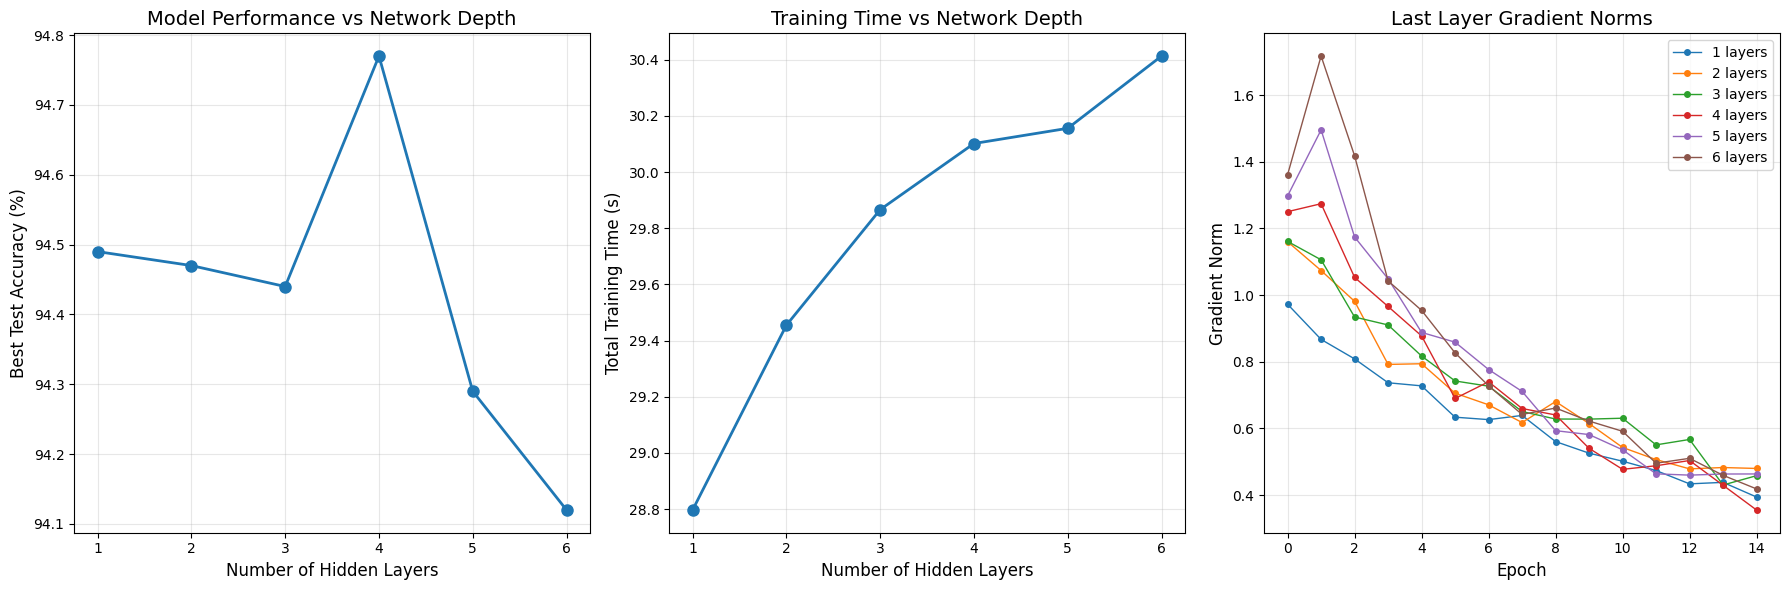


Depth Analysis:
Depth  Best Acc   Final Loss   Total Time Last Grad Norm 
------------------------------------------------------------
1      94.49      0.0558       28.80      0.394031       
2      94.47      0.0448       29.45      0.479742       
3      94.44      0.0441       29.87      0.458089       
4      94.77      0.0347       30.10      0.355004       
5      94.29      0.0493       30.16      0.463255       
6      94.12      0.0418       30.41      0.418369       


In [7]:
def experiment_network_depth():
    input_size = 28*28
    output_size = 10
    epochs = 15
    hidden_units = 64

    depths = [1, 2, 3, 4, 5, 6]
    results = {}

    print("\n" + "="*60)
    print("EXPERIMENT 3: NETWORK DEPTH IMPACT")
    print("="*60 + "\n")

    for depth in depths:
        hidden_sizes = [hidden_units] * depth
        model = SimpleDNN(input_size, hidden_sizes, output_size, nn.ReLU())
        results[depth] = train_model(model, train_loader, test_loader, epochs=epochs)


    plt.figure(figsize=(18, 6))


    plt.subplot(1, 3, 1)
    final_accuracies = [max(results[d]['test_acc']) for d in depths]
    plt.plot(depths, final_accuracies, 'o-', linewidth=2, markersize=8)
    plt.xlabel('Number of Hidden Layers', fontsize=12)
    plt.ylabel('Best Test Accuracy (%)', fontsize=12)
    plt.title('Model Performance vs Network Depth', fontsize=14)
    plt.xticks(depths)
    plt.grid(True, alpha=0.3)


    plt.subplot(1, 3, 2)
    training_times = [np.sum(results[d]['epoch_times']) for d in depths]
    plt.plot(depths, training_times, 'o-', linewidth=2, markersize=8)
    plt.xlabel('Number of Hidden Layers', fontsize=12)
    plt.ylabel('Total Training Time (s)', fontsize=12)
    plt.title('Training Time vs Network Depth', fontsize=14)
    plt.xticks(depths)
    plt.grid(True, alpha=0.3)


    plt.subplot(1, 3, 3)
    for depth in depths:

        last_layer_key = f'layer_{2*depth}_grad_norm'
        grad_norms = results[depth]['grad_norms'][last_layer_key]
        plt.plot(grad_norms, 'o-', label=f'{depth} layers', linewidth=1, markersize=4)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Gradient Norm', fontsize=12)
    plt.title('Last Layer Gradient Norms', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


    print("\nDepth Analysis:")
    print(f"{'Depth':<6} {'Best Acc':<10} {'Final Loss':<12} {'Total Time':<10} {'Last Grad Norm':<15}")
    print("-"*60)
    for depth in depths:
        best_acc = max(results[depth]['test_acc'])
        final_loss = results[depth]['train_loss'][-1]
        total_time = np.sum(results[depth]['epoch_times'])
        last_grad_norm = results[depth]['grad_norms'][f'layer_{2*depth}_grad_norm'][-1]
        print(f"{depth:<6} {best_acc:<10.2f} {final_loss:<12.4f} {total_time:<10.2f} {last_grad_norm:<15.6f}")


experiment_network_depth()